# Clustering

What is clustering? When do we use it? How does it make sense in the context of single-cell RNA-seq analysis?

## Coming up with a clustering scheme

Input: normalised data matrix of size $N \times G$, where $N$ is the number of observations (cells) and $G$ is the number of variables.
Output: a vector of size $N$ that contains the cluster assignment for each observation.

Michelle algorithm:
1. calculate the distance matrix $D \in N \times N$ between all observations
2. all observations with a distance below a threshold $L$ are in the same cluster!

```
a-b----------x
  |
  c
```

```
  a   b   c   x
a 0   1   2   11
b 1   0   1   10
c 2   1   0   11
x 11  10  11  0
```

Threshold = 1:
- 1st row: (a,b)
- 2nd row: (a,b,c)
- 3rd row: (b,c)
- 4th row: ()

--> just thresholding means that we could be placing the same observation in multiple clusters.

## Practicing community clustering on single-cell data:

Use the Leiden algorithm to cluster the PBMC data. Apply your favorite normalisation and variance stabilisation. Calculate pairwise cell distances using both PCA and using the normalised/transformed counts. Cluster both at the same resolution, and compare the clustering results.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
adata = sc.read_h5ad("/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/pbmc3k/pbmc3k_raw.h5ad")

In [3]:
annot = pd.read_csv("/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/pbmc3k/pbmc3k_annot.csv")
annot.set_index("index", inplace=True)
adata.obs = adata.obs.join(annot)

In [4]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [5]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [6]:
sc.pp.neighbors(adata, use_rep="X", key_added="only_genes")

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packag

In [7]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'only_genes'
    obsp: 'only_genes_distances', 'only_genes_connectivities'

In [8]:
sc.pp.pca(adata, n_comps=20)
sc.pp.neighbors(adata, use_rep="X_pca", n_pcs=10, key_added="pca")

In [9]:
adata


AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'only_genes', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'only_genes_distances', 'only_genes_connectivities', 'pca_distances', 'pca_connectivities'

In [10]:
sc.tl.leiden(adata, neighbors_key="only_genes", key_added="only_genes")

In [11]:
sc.tl.leiden(adata, neighbors_key="pca", key_added="pca")

In [12]:
sc.tl.umap(adata, neighbors_key="pca")

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


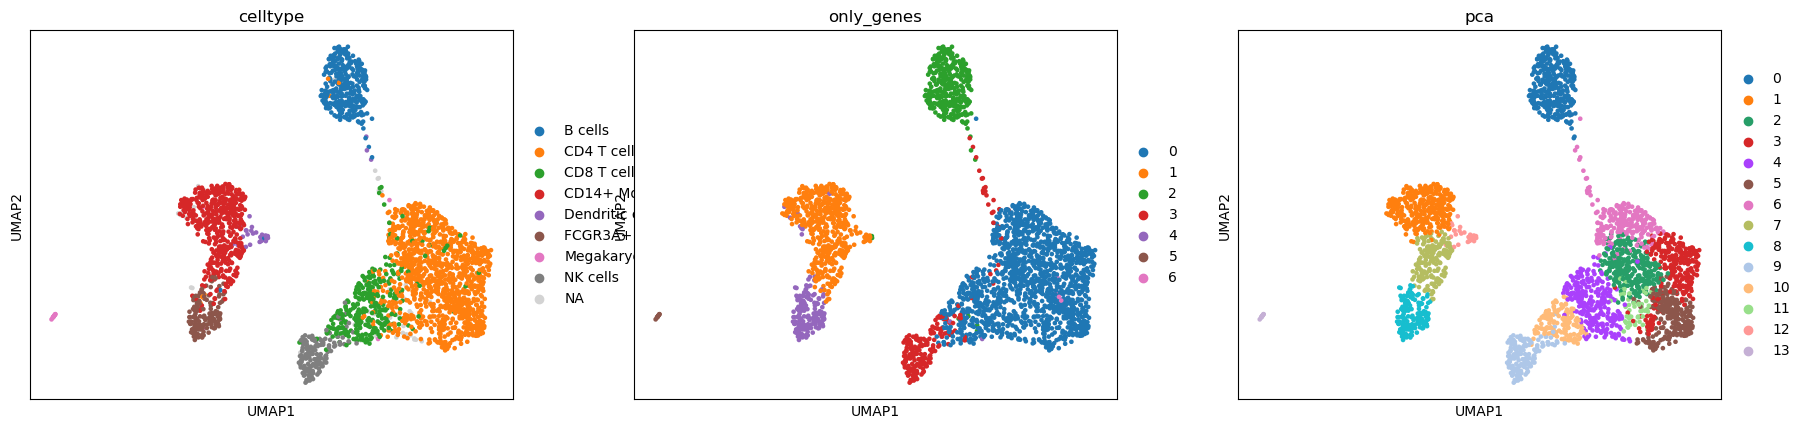

In [13]:
sc.pl.umap(adata, color=["celltype", "only_genes", "pca"])

## AASCD Master Plan For Finding Cell Types From Clusters

1. We want to have clusters that correspond to cell types.
2. Our evolutionary theory of cell types predicts that there should be a number of genes (probably dozens of them) that is specifically expressed in the cell type (along with a CoRC).
3. Our proxy for finding specifically expressed genes is to look for differential expression. BUT: it is important to compare pairs of clusters to each other rather than each cluster to the background (example: one gene is DE in two clusters; comparing against the background this is lost).
4. it is easier to find the true cell types if we overcluster and merge rather than underclustering, as it is not clear how we should split. We noticed that in fused clusters the true expression patterns will get blurred.

Algorithm:

- overcluster!
- calculate pairwise similarity between all clusters
- look at two most similar clusters A, B:
    - look at DGE between A and B.
    - we need at least X genes to be specific for A and X genes to be specific for B.
    - if true, go to next most similar pair.
    - otherwise, A, B get merged; go to previous step.

In [62]:
import cluster

In [64]:
adata.raw = adata

In [76]:
cluster.merge_clusters(adata, "pca", num_genes=85)

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


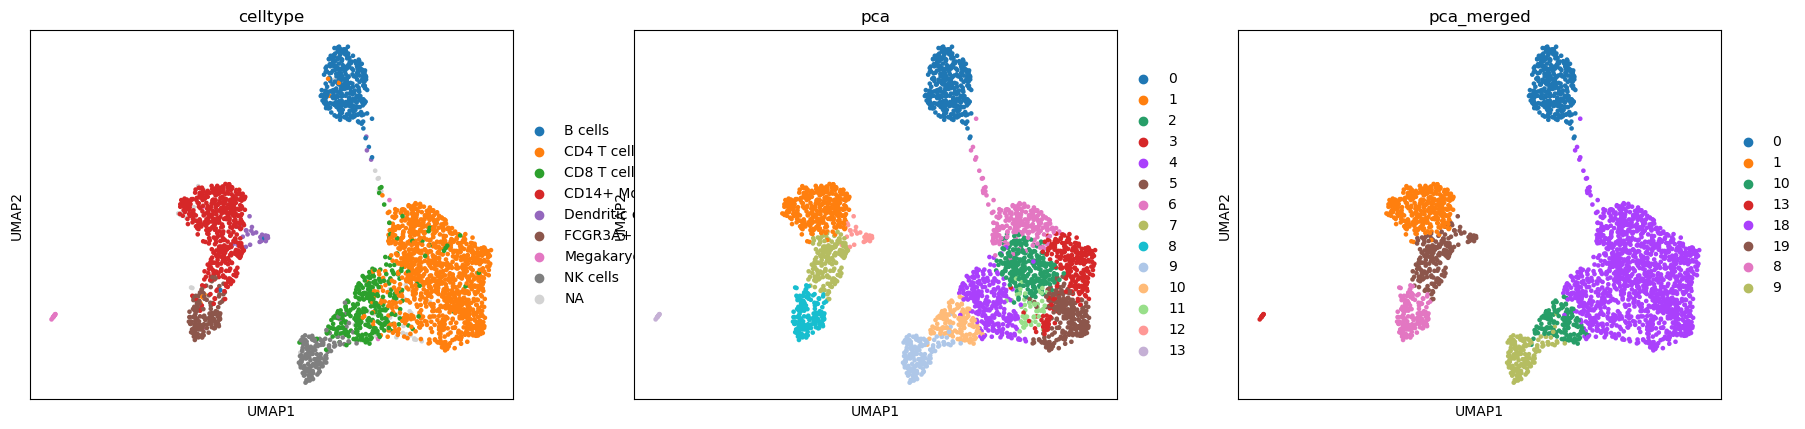

In [77]:
sc.pl.umap(adata, color=["celltype", "pca", "pca_merged"])

In [85]:
sc.tl.paga(adata, groups="pca_merged", neighbors_key="pca")

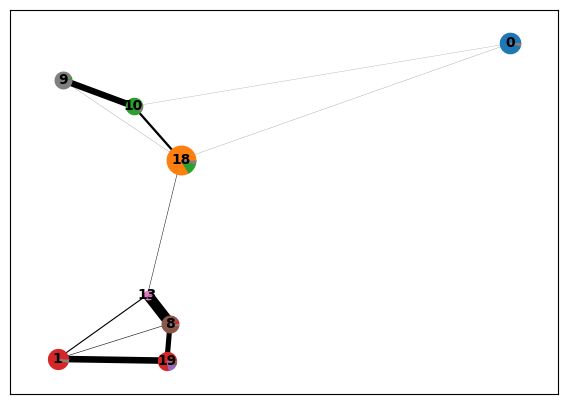

In [87]:
sc.pl.paga(adata, color="celltype")

In [88]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [ ]:
log_norm = cluster.grouped_obs_mean(adata, "pca_merged")

%%R
library(stats)
library(ape)

%%R -i log_norm
pdum_distance_matrix <- dist(t(log_norm), method = "euclidean")
nj.tree <- nj(pdum_distance_matrix)

nj.boot.tree <- boot.phylo(nj.tree, t(log_norm), FUN = function(xx) nj(dist(xx)), B = 1000)

nj.tree$node.label <- nj.boot.tree/100
nj.tree$node.label <- round(nj.tree$node.label)

node_col <- nj.tree$node.label
node_col[nj.tree$node.label < 80] <- "yellow"
node_col[nj.tree$node.label < 50] <- "red"
node_col[nj.tree$node.label >= 80] <- "black"
nj.tree$edge.length <- sqrt(nj.tree$edge.length)

%%R
png(file="./bootstrap.png", width=700, height=500)
plot.phylo(nj.tree, type = "unrooted", show.node.label = TRUE, label.offset = 0.1, rotate.tree = 90)
title(main="PCA_merged | bootstrap replicates: 10000 | log1p norm | all genes")
for (i in 1:length(node_col)) {
  nodelabels(node = length(nj.tree$tip.label)+i, pch=21, col="black", bg=node_col[i], cex=2)
}
dev.off()

In [59]:
test = [0, 5, 2, 4, 7]

In [60]:
np.sort(test)

array([0, 2, 4, 5, 7])

In [61]:
np.argsort(test)

array([0, 2, 3, 1, 4])

In [45]:
adata.X.mean(), adata.X.min(), adata.X.max()

(0.024621721, 0.0, 5.955077)

In [46]:
adata.obsm["X_pca"][:, :10].mean() , adata.obsm["X_pca"][:, :10].min(), adata.obsm["X_pca"][:, :10].max()

(-6.879877e-07, -6.4013467, 16.67953)

In [57]:
adata.obsp["only_genes_distances"].mean()

0.12678231134323098

In [58]:
adata.obsp["pca_distances"].mean()

0.0114402004591395

In [33]:
adata.obsp["only_genes_connectivities"]

<2700x2700 sparse matrix of type '<class 'numpy.float32'>'
	with 74408 stored elements in Compressed Sparse Row format>

In [34]:
adata.obsp["pca_connectivities"]

<2700x2700 sparse matrix of type '<class 'numpy.float32'>'
	with 53358 stored elements in Compressed Sparse Row format>

In [38]:
from tqdm import tqdm

In [51]:
import sys

In [57]:
def confusion_matrix(pred, truth):
    # we have to compare all pairs in pred to all pairs in truth
    N = len(pred)
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for cell1 in tqdm(range(N)):
        for cell2 in range(cell1+1, N):
            # positive:
            prediction = pred[cell1] == pred[cell2]
            actual = truth[cell1] == truth[cell2]
            if prediction is True and actual is True:
                TP += 1
            elif prediction is True and actual is False:
                FP += 1
            elif prediction is False and actual is True:
                FN += 1
            elif prediction is False and actual is False:
                TN += 1
            else:
                print(pred[cell1], pred[cell2])
                print(prediction, actual)
                print("ERROR")
                sys.exit()
    return TP, FP, TN, FN

In [32]:
# example to test if it even runs
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
confusion_matrix(a, b)

(0, 0, 0, 45)

In [33]:
# example to test if it even runs
a = [1, 1, 3, 4, 5, 6, 7, 8, 9, 10]
b = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
confusion_matrix(a, b)

(1, 0, 0, 44)

In [34]:
# example to test if it even runs
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
confusion_matrix(b, a)

(0, 45, 0, 0)

In [35]:
confusion_matrix(a, a)

(0, 0, 45, 0)

In [36]:
confusion_matrix(b, b)

(45, 0, 0, 0)

In [40]:
confusion_matrix(adata.obs["only_genes"], adata.obs["celltype"])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:29<00:00, 91.27it/s]


(849036, 414182, 2328904, 51528)

In [41]:
confusion_matrix(adata.obs["pca"], adata.obs["celltype"])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:29<00:00, 90.86it/s]


(284170, 47674, 2695412, 616394)

In [61]:
# random prediction:
random_prediction = np.random.randint(0, 8, size=2700).astype(str)

In [63]:
confusion_matrix(random_prediction, adata.obs["celltype"])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:16<00:00, 164.28it/s]


(112588, 342066, 2401020, 787976)

TP, FP, TN, FN

In [65]:
# cheating prediction:
all_one_cluster = ["0"] * 2700
confusion_matrix(all_one_cluster, adata.obs["celltype"])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:14<00:00, 181.32it/s]


(900564, 2743086, 0, 0)

In [66]:
# Precision:
# genes only:
print(849036 / (849036 + 51528))
# pca
print(284170 / (284170 + 616394))
# random
print(112588 / (112588 + 787976))
# cheating
print(900564 / (900564 + 0))

0.9427825229522833
0.3155467018446218
0.12501943226689052
1.0
